In [3]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
from sklearn.linear_model import (LinearRegression, LogisticRegression, Lasso)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from sklearn.model_selection import (train_test_split, GridSearchCV)

In [4]:
import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset

In [5]:
# torchmetrics can compare various metrics to evaluate model
from torchmetrics import MeanAbsoluteError, R2Score
# torchinfo provides useful summary of layers of a model
from torchinfo import summary
from torchvision.io import read_image
# pytorch_lightning simplifies model fitting by reducing boilerplate
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
# seed_everything makes results reproduceable
torch.manual_seed(0)
torch.use_deterministic_algorithms(True, warn_only=True)

In [6]:
# torchvision has datasets
from torchvision.datasets import MNIST, CIFAR100
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.transforms import Resize, Normalize, CenterCrop, ToTensor

In [7]:
from ISLP.torch import SimpleDataModule, SimpleModule, ErrorTracker, rec_num_workers
from ISLP.torch.imdb import load_lookup, load_tensor, load_sparse, load_sequential

In [8]:
# glob function finds all files matching wildcard characters
from glob import glob
import json

In [9]:
Hitters = load_data('Hitters').dropna()
n = Hitters.shape[0]

In [8]:
# We will fit two linear models(least squares and lasso) and compare to neural network via mean absolute error
model = MS(Hitters.columns.drop('Salary'), intercept=False)
# Convert pandas dfs to numpy arrays
X = model.fit_transform(Hitters).to_numpy()
Y = Hitters['Salary'].to_numpy() 

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=1/3,
                                                    random_state=1)

In [10]:
# Linear Model
hit_lm = LinearRegression().fit(X_train, Y_train)
Yhat_test = hit_lm.predict(X_test)
# Test Error
np.abs(Yhat_test - Y_test).mean()

259.71528833146243

In [11]:
# We perform cross validation directly because the solver we used before only works with MSE
# Encode pipeline with two steps: 1. normalize features 2. fit lasso
scaler = StandardScaler(with_mean=True, with_std=True)
lasso = Lasso(warm_start=True, max_iter=3000)
standard_lasso = Pipeline(steps=[('scaler', scaler),
                                 ('lasso', lasso)])

In [12]:
# Create grid of 100 values for lambda, uniform on log scale from lam_max to 0.01*lam_max
X_s = scaler.fit_transform(X_train)
n = X_s.shape[0]
lam_max = np.fabs(X_s.T.dot(Y_train - Y_train.mean())).max() / n
# Note that lam_max = smallest lambda with all zero solution = largest |innerproduct between predictor and response|
param_grid = {'alpha': np.exp(np.linspace(0, np.log(0.01), 100))
              * lam_max}

In [13]:
# Perform CV 
cv = KFold(10, shuffle=True, random_state=1)
grid = GridSearchCV(lasso,
                    param_grid,
                    cv=cv,
                    scoring='neg_mean_absolute_error')
grid.fit(X_train, Y_train);

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.197e+04, tolerance: 3.473e+03
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.363e+04, tolerance: 3.473e+03
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

In [14]:
trained_lasso = grid.best_estimator_
Y_hat_test = trained_lasso.predict(X_test)
np.fabs(Yhat_test - Y_test).mean()

259.71528833146243

In [15]:
# Specifying a Network : Classes and Inheritance

In [16]:
# Inherets from nn.Module class
class HittersModel(nn.Module):
    # Called when instance of class is created
    def __init__(self, input_size):
        # super allows us to call methods from nn.Module
        super(HittersModel, self).__init__()
        self.flatten = nn.Flatten()
        # Composition of four maps
        self.sequential = nn.Sequential(
            # maps 19 features of Hittres to 50 dimensions
            nn.Linear(input_size, 50),
            # map to ReLU layer
            nn.ReLU(),
            # 40 percent dropout layer
            nn.Dropout(0.4),
            # linear map down to 1 dimension
            nn.Linear(50, 1))
    # Describes the map that this module implements??
    def forward(self, x):
        x = self.flatten(x)
        return torch.flatten(self.sequential(x))
        

In [17]:
hit_model = HittersModel(X.shape[1])
# torchinfo summary
summary(hit_model,
        input_size=X_train.shape,
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
HittersModel                             [175, 19]                 [175]                     --
├─Flatten: 1-1                           [175, 19]                 [175, 19]                 --
├─Sequential: 1-2                        [175, 19]                 [175, 1]                  --
│    └─Linear: 2-1                       [175, 19]                 [175, 50]                 1,000
│    └─ReLU: 2-2                         [175, 50]                 [175, 50]                 --
│    └─Dropout: 2-3                      [175, 50]                 [175, 50]                 --
│    └─Linear: 2-4                       [175, 50]                 [175, 1]                  51
Total params: 1,051
Trainable params: 1,051
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.18
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 0.00
Estimated Total Size (MB): 0.09

In [18]:
# Tranform data to be accessible to torch ( 32-bit tensors)
X_train_t = torch.tensor(X_train.astype(np.float32))
Y_train_t = torch.tensor(Y_train.astype(np.float32))
hit_train = TensorDataset(X_train_t, Y_train_t)

X_test_t = torch.tensor(X_test.astype(np.float32))
Y_test_t = torch.tensor(Y_test.astype(np.float32))
hit_test = TensorDataset(X_test_t, Y_test_t)

In [13]:
# Pass dataset into DataLoader() which passes data into our network
# helpful for when data lives on different machines or is processed using GPU
# SimpleDataModule() in ISLP makes this easier
max_num_workers = rec_num_workers()

In [20]:
# Generally in pytorch_lighting our dataset is split into training, validation, and test 
# during each epoch we run training and validation to estimate error
# we'll use test as validation data
hit_dm = SimpleDataModule(hit_train,
                          hit_test,
                          batch_size=32,
                          num_workers=min(4, max_num_workers),
                          validation=hit_test)

In [21]:
# We'll use squared error loss, but we also want MAE to be tracked
hit_module = SimpleModule.regression(hit_model,
                                     metrics={'mae':MeanAbsoluteError()})

In [22]:
# Stores the results in logs/hitters
hit_logger = CSVLogger('logs', name='hitters')

In [23]:

hit_trainer = Trainer(deterministic=True,
                      max_epochs=50,
                      log_every_n_steps=5,
                      logger=hit_logger,
                      callbacks=[ErrorTracker()]) # callbacks allows for several tasks to be carried out at various points while training
# datamodule telsl trainer how train/validation/test logs are produced
# hit_module specidies network architecture
hit_trainer.fit(hit_module, datamodule=hit_dm) 

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | HittersModel | 1.1 K  | train
1 | loss  | MSELoss      | 0      | train
-----------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [24]:
# Evaluate test performance
hit_trainer.test(hit_module, datamodule=hit_dm)

Testing: |                                                | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss             107904.6484375
        test_mae            221.83148193359375
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 107904.6484375, 'test_mae': 221.83148193359375}]

In [25]:
# Retrieve logged summaries
hit_results = pd.read_csv(hit_logger.experiment.metrics_file_path)

In [7]:
# Plotting function
def summary_plot(results,
                 ax, 
                 col='loss',
                 valid_legend='Validation',
                 training_legend='Training',
                 ylabel='Loss',
                 fontsize=20):
    for (column,
         color,
         label) in zip([f'train_{col}_epoch',
                        f'valid_{col}'],
                       ['black', 'red'],
                       [training_legend,
                        valid_legend]):
        results.plot(x='epoch',
                     y=column,
                     label=label,
                     marker='o',
                     color=color,
                     ax=ax)
        ax.set_xlabel('Epoch')
        ax.set_ylabel(ylabel)
        return ax

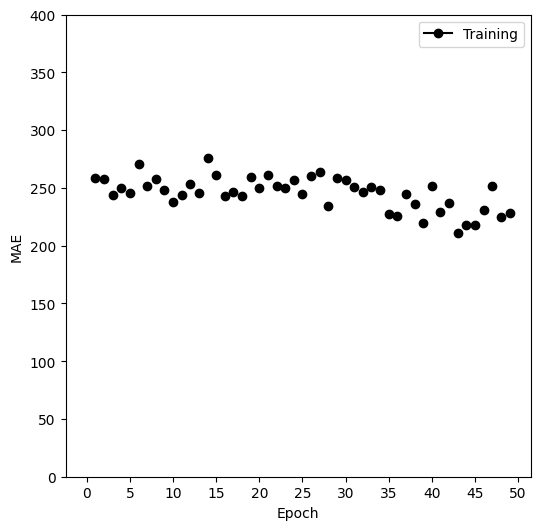

In [28]:
# Use function to produce MAE plot
fig, ax = subplots(1,1,figsize=(6,6))
ax = summary_plot(hit_results, ax, col='mae', ylabel='MAE', valid_legend='Validation (=Test)')
ax.set_ylim([0, 400])
ax.set_xticks(np.linspace(0, 50, 11).astype(int));

In [29]:
# using .eval() lets pytorch know we're done training model, so we don't randomly drop neurons
hit_model.eval()
preds = hit_module(X_test_t)
torch.abs(Y_test_t - preds).mean()

tensor(221.8315, grad_fn=<MeanBackward0>)

In [30]:
# Cleanup: stop remaining worker processes
del(Hitters,
    hit_model, hit_dm,
    hit_logger,
    hit_test, hit_train,
    X, Y,
    X_test, X_train,
    Y_test, Y_train,
    X_test_t, Y_test_t,
    hit_trainer, hit_module)

In [9]:
mnist_train, mnist_test = [MNIST(root='data',
                                 train=train,
                                 download=True,
                                 transform=ToTensor()) # ToTensor also scales data to [0 1]
                           for train in [True, False]]
mnist_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [12]:
# Set aside 20% of training images for validation
mnist_dm = SimpleDataModule(mnist_train,
                            mnist_test,
                            validation=0.2,
                            num_workers=max_num_workers,
                            batch_size=256) #

In [16]:
# Look at data in first two batches
for idx, (X_, Y_) in enumerate(mnist_dm.train_dataloader()):
    print('X: ', X_.shape)
    print('Y: ', Y_.shape)
    if idx >= 1:
        break
# Each batch has 256 images, 1 channel (greyscale) and 28x28 pixels

X:  torch.Size([256, 1, 28, 28])
Y:  torch.Size([256])
X:  torch.Size([256, 1, 28, 28])
Y:  torch.Size([256])


In [17]:
# Neural Network
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256), # image is flattened and mapped to 256 dimensions
            nn.ReLU(),
            nn.Dropout(0.4))
        self.layer2 = nn.Sequential(
            nn.Linear(256, 128), # map down to 128 dimensions
            nn.ReLU(),
            nn.Dropout(0.3))
        self._forward = nn.Sequential(
            self.layer1,
            self.layer2,
            nn.Linear(128, 10)) # finally map down to 10, number of classes in MNIST
    def forward(self, x):
        return self._forward(x)

In [18]:
mnist_model = MNISTModel()

In [19]:
# Check that model produces output of expected size
mnist_model(X_).size()

torch.Size([256, 10])

In [20]:
summary(mnist_model,
        input_data=X_, # instead of input_size we pass tensor of correct shape
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
MNISTModel                               [256, 1, 28, 28]          [256, 10]                 --
├─Sequential: 1-1                        [256, 1, 28, 28]          [256, 10]                 --
│    └─Sequential: 2-1                   [256, 1, 28, 28]          [256, 256]                --
│    │    └─Flatten: 3-1                 [256, 1, 28, 28]          [256, 784]                --
│    │    └─Linear: 3-2                  [256, 784]                [256, 256]                200,960
│    │    └─ReLU: 3-3                    [256, 256]                [256, 256]                --
│    │    └─Dropout: 3-4                 [256, 256]                [256, 256]                --
│    └─Sequential: 2-2                   [256, 256]                [256, 128]                --
│    │    └─Linear: 3-5                  [256, 256]                [256, 128]                32,896
│    │    └─ReLU: 3-6     

In [22]:
# Now fitting model is almost identical to Hitters dataset
mnist_module = SimpleModule.classification(mnist_model, num_classes=10) # this method uses cross-entropy loss instead of MSE
mnist_logger = CSVLogger('logs', name='MNIST')

In [24]:
mnist_trainer = Trainer(deterministic=True,
                        max_epochs=30,
                        logger=mnist_logger,
                        callbacks=[ErrorTracker()])
mnist_trainer.fit(mnist_module,
                  datamodule=mnist_dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: logs/MNIST

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | MNISTModel       | 235 K  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
235 K     Trainable params
0         Non-trainable params
235 K     Total params
0.941     Total estimated model params size (MB)


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


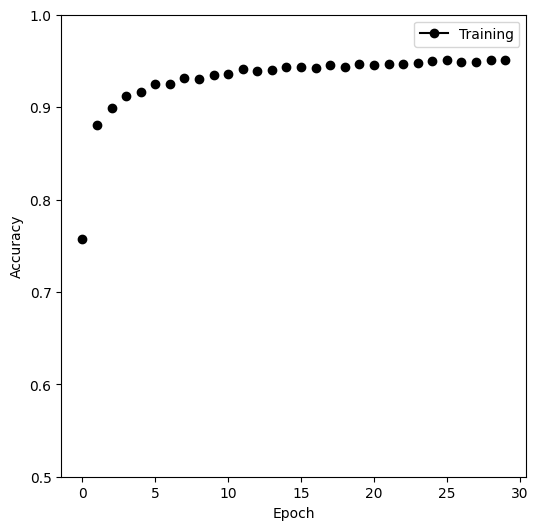

In [29]:
mnist_results = pd.read_csv(mnist_logger.experiment.metrics_file_path)
fig, ax = subplots(1,1, figsize=(6,6))
summary_plot(mnist_results, ax, col='accuracy', ylabel='Accuracy')
ax.set_ylim([0.5,1])
ax.set_ylabel('Accuracy')
ax.set_xticks(np.linspace(0, 30, 7).astype(int));

In [31]:
# evaluate test accuracy
mnist_trainer.test(mnist_module, datamodule=mnist_dm)

Testing: |                                                | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9666000008583069     │
│         test_loss         │    0.14738056063652039    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.14738056063652039, 'test_accuracy': 0.9666000008583069}]

In [34]:
# Fitting multiple logistic regression (mlr) with input and output layer instead of sklearn
class MNIST_MLR(nn.Module):
    def __init__(self):
        super(MNIST_MLR, self).__init__()
        self.linear = nn.Sequential(nn.Flatten(), nn.Linear(784, 10)) # flatten all at once
    def forward(self, x):
        return self.linear(x)

mlr_model = MNIST_MLR()
mlr_module = SimpleModule.classification(mlr_model, 10)
mlr_logger = CSVLogger('logs', name='MNIST_MLR')

In [35]:
mlr_trainer = Trainer(deterministic=True,
                      max_epochs=30,
                      callbacks=[ErrorTracker()])
mlr_trainer.fit(mlr_module, datamodule=mnist_dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: /Users/ritenpatel/Desktop/Statistical Learning/Chapter 10 - Deep Learning/lightning_logs

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | MNIST_MLR        | 7.9 K  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.031     Total estimated model params size (MB)


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [36]:
mlr_trainer.test(mlr_module,
                 datamodule=mnist_dm)
# Note the accuracy is good, but not as robust as the NN

Testing: |                                                | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9143999814987183     │
│         test_loss         │    0.3456619381904602     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.3456619381904602, 'test_accuracy': 0.9143999814987183}]

In [37]:
del(mnist_test,
    mnist_train,
    mnist_model,
    mnist_dm,
    mnist_trainer,
    mnist_module,
    mnist_results,
    mlr_model,
    mlr_module,
    mlr_trainer)

In [11]:
# Convolutional Neural Networks

cifar_train, cifar_test = [CIFAR100(root="data",
                                    train=train,
                                    download=True)
                           for train in [True, False]]

Files already downloaded and verified
Files already downloaded and verified


In [12]:
# Dataset has 50k images, each rep by three dim tensor, each three color is rep as a set of three channels
transform = ToTensor()
cifar_train_X = torch.stack([transform(x) for x in 
                             cifar_train.data])
cifar_test_X = torch.stack([transform(x) for x in
                            cifar_test.data])
cifar_train = TensorDataset(cifar_train_X,
                            torch.tensor(cifar_train.targets))
cifar_test = TensorDataset(cifar_test_X,
                           torch.tensor(cifar_test.targets))

In [14]:
# Create data module
cifar_dm = SimpleDataModule(cifar_train,
                            cifar_test,
                            validation=0.2,
                            num_workers=max_num_workers,
                            batch_size=128)

In [15]:
# Look at shape of batches
for idx, (X_, Y_) in enumerate(cifar_dm.train_dataloader()):
    print('X: ', X_.shape)
    print('Y: ', Y_.shape)
    if idx >= 1:
        break
# 128 images, three channels, 32x32 pixels

X:  torch.Size([128, 3, 32, 32])
Y:  torch.Size([128])
X:  torch.Size([128, 3, 32, 32])
Y:  torch.Size([128])


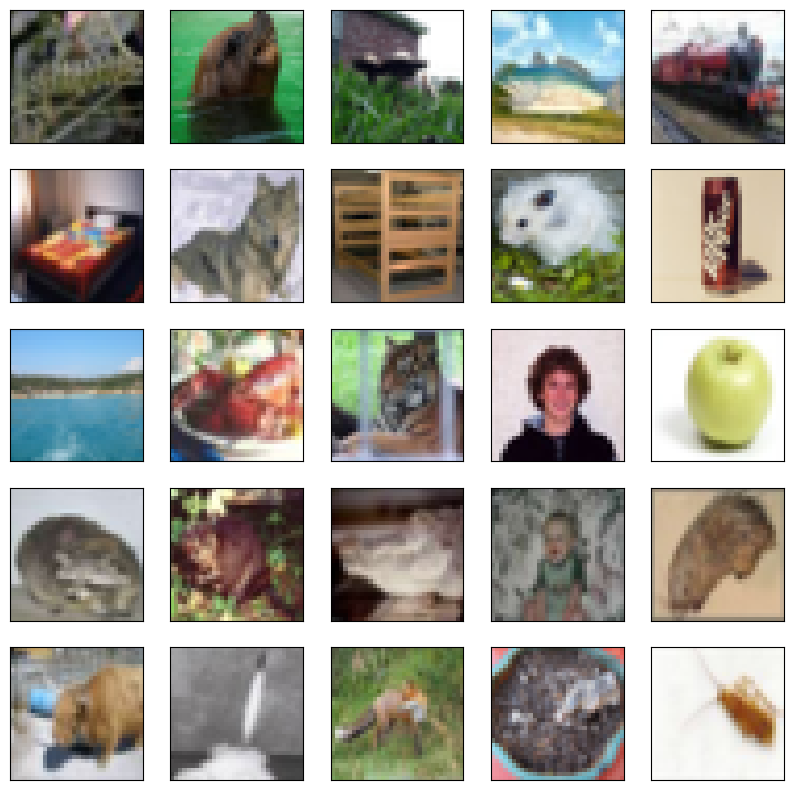

In [22]:
# Look at some training images
fig, axes = subplots(5,5,figsize=(10,10))
rng = np.random.default_rng(4)
# Choose random indices
indices = rng.choice(np.arange(len(cifar_train)), 25,
                     replace=False).reshape((5,5))
for i in range(5):
    for j in range(5):
        idx = indices[i,j]
        # Tensors can be indexed by integers
        # Transpose to display correctly
        axes[i,j].imshow(np.transpose(cifar_train[idx][0],
                                     [1,2,0]),
                                     interpolation=None)
        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])

In [26]:
# Defining a module that will be one layer of CNN
# This module can be used like nn.Linear() or nn.Dropout()
class BuildingBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super(BuildingBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels,
                             out_channels=out_channels,
                             kernel_size=(3,3), # 3x3 convolution filter for each channel
                             padding='same') # same padding := dim(ouptput channel) = dim(input channel_
        self.activation = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=(2,2)) # max pooling over 2x2, so each dimension will be half
        
    def forward(self, x):
        return self.pool(self.activation(self.conv(x)))

In [27]:
# Our full network
class CIFARModel(nn.Module):
    def __init__(self):
        super(CIFARModel, self).__init__()
        sizes = [(3,32),
                 (32,64),
                 (64,128),
                 (128,256)]
        self.conv = nn.Sequential(*[BuildingBlock(in_, out_)
                                    for in_, out_ in sizes])
        self.output = nn.Sequential(nn.Dropout(0.5), # 50% dropout
                                   nn.Linear(2*2*256, 512), # map down to 512
                                   nn.ReLU(),
                                   nn.Linear(512,100)) # map down to 100
    def forward(self,x):
        val = self.conv(x)
        val = torch.flatten(val, start_dim=1)
        return self.output(val)
        

In [28]:
cifar_model = CIFARModel()
summary(cifar_model,
        input_data=X_,
        col_names=['input_size',
                   'output_size',
                   'num_params'])
# pool halves the dimensions of channels
# After all popoling, we have layer with 256 2x2 channels, we flatten to 1024 vector
# dropout layer and resize to 100

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
CIFARModel                               [128, 3, 32, 32]          [128, 100]                --
├─Sequential: 1-1                        [128, 3, 32, 32]          [128, 256, 2, 2]          --
│    └─BuildingBlock: 2-1                [128, 3, 32, 32]          [128, 32, 16, 16]         --
│    │    └─Conv2d: 3-1                  [128, 3, 32, 32]          [128, 32, 32, 32]         896
│    │    └─ReLU: 3-2                    [128, 32, 32, 32]         [128, 32, 32, 32]         --
│    │    └─MaxPool2d: 3-3               [128, 32, 32, 32]         [128, 32, 16, 16]         --
│    └─BuildingBlock: 2-2                [128, 32, 16, 16]         [128, 64, 8, 8]           --
│    │    └─Conv2d: 3-4                  [128, 32, 16, 16]         [128, 64, 16, 16]         18,496
│    │    └─ReLU: 3-5                    [128, 64, 16, 16]         [128, 64, 16, 16]         --
│    │    └─MaxPool2d: 3-6    

In [30]:
cifar_optimizer = RMSprop(cifar_model.parameters(), lr=0.001) # default= 0.01, but experimentally 0.001 better on CIFAR
cifar_module = SimpleModule.classification(cifar_model,
                                           num_classes=100,
                                           optimizer=cifar_optimizer)
cifar_logger = CSVLogger('logs', name='CIFAR100')

In [32]:
# Optimized code for apple silicon:
try:
    for name,metric in cifar_module.metrics.items():
        cifar_module.metrics[name] = metric.to('mps')
    cifar_trainer_mps = Trainer(accelerator='mps',
                                deterministic=True,
                                max_epochs=30)
    cifar_trainer_mps.fit(cifar_module,
                          datamodule=cifar_dm)
    cifar_trainer_mps.test(cifar_module,
                           datamodule=cifar_dm)
except:
    pass

# Code that will work on any machine:
#cifar_trainer = Trainer(deterministic=True,
#                        max_epochs=30,
#                        logger=cifar_logger,
#                        callbacks=[ErrorTracker()])
#cifar_trainer.fit(cifar_module,
#                  datamodule=cifar_dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | CIFARModel       | 964 K  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
964 K     Trainable params
0         Non-trainable params
964 K     Total params
3.858     Total estimated model params size (MB)


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


Testing: |                                                | 0/? [00:00<?, ?it/s]

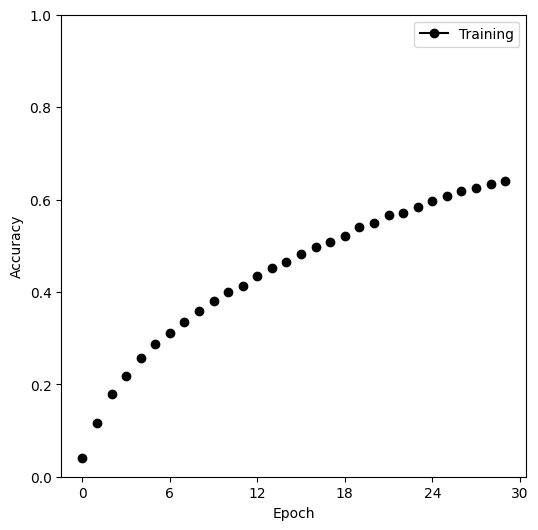

In [37]:
log_path = cifar_logger.experiment.metrics_file_path
cifar_results = pd.read_csv(log_path)
fig, ax = subplots(1,1, figsize=(6,6))
summary_plot(cifar_results,
             ax,
             col='accuracy',
             ylabel='Accuracy')
ax.set_xticks(np.linspace(0, 30, 6).astype(int))
ax.set_ylabel('Accuracy')
ax.set_ylim([0,1]);

In [38]:
# Evaluate model in test data
cifar_trainer.test(cifar_module,
                   datamodule=cifar_dm)
# 42 % accuracy, the best models with tedious tinkering have 75%

Testing: |                                                | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.4260999858379364     │
│         test_loss         │    2.8998711109161377     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 2.8998711109161377, 'test_accuracy': 0.4260999858379364}]

In [44]:
# Using pretrained CNNs (resnet50)
# We will convert images to array format to match resnet50 specifications (resize, crop, standardization)
resize = Resize((232,232))
crop = CenterCrop(224)
normalize = Normalize([0.485, 0.456, 0.406], # means for each channel
                      [0.229,0.224,0.225]) # std for each channel
imgfiles = sorted([f for f in glob('book_images/*')])
imgs = torch.stack([torch.div(crop(resize(read_image(f))), 255) # stack concatenates tensors, div = divide by 255
                   for f in imgfiles])
imgs.size()

torch.Size([5, 3, 224, 224])

In [48]:
# set up trained network with weights we read in code block 6
resnet_model = resnet50(weights=ResNet50_Weights.DEFAULT)
summary(resnet_model,
        input_data=imgs,
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/ritenpatel/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████████████████████████████████| 97.8M/97.8M [00:09<00:00, 10.7MB/s]


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
ResNet                                   [5, 3, 224, 224]          [5, 1000]                 --
├─Conv2d: 1-1                            [5, 3, 224, 224]          [5, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [5, 64, 112, 112]         [5, 64, 112, 112]         128
├─ReLU: 1-3                              [5, 64, 112, 112]         [5, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [5, 64, 112, 112]         [5, 64, 56, 56]           --
├─Sequential: 1-5                        [5, 64, 56, 56]           [5, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [5, 64, 56, 56]           [5, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [5, 64, 56, 56]           [5, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [5, 64, 56, 56]           [5, 64, 56, 56]           128
│    │    └─ReLU: 3-3      

In [49]:
# Set to eval to ensure model is ready to predict on new data
resnet_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [50]:
# Get predictions
img_preds = resnet_model(imgs)

In [52]:
# 1. compute probabilites by applying softmax to logits
img_probs = np.exp(np.asarray(img_preds.detach())) # .detach() converts to ndarray
img_probs /= img_probs.sum(1)[:,None]

In [56]:
# class labels downloaded online
labs = json.load(open('imagenet_class_index.json'))
class_labels = pd.DataFrame([(int(k), v[1]) for k, v in 
                            labs.items()],
                           columns=['idx','label'])
class_labels = class_labels.set_index('idx')
class_labels = class_labels.sort_index()

In [58]:
# Construct data fram for each image file with labels iwth three highest probabilities
for i, imgfile in enumerate(imgfiles):
    img_df = class_labels.copy()
    img_df['prob'] = img_probs[i]
    img_df = img_df.sort_values(by='prob', ascending=False)[:3]
    print(f'Image: {imgfile}')
    print(img_df.reset_index().drop(columns=['idx']))

Image: book_images/Cape_Weaver.jpg
       label      prob
0    jacamar  0.338407
1  bee_eater  0.089356
2     bulbul  0.024197
Image: book_images/Hawk_Fountain.jpg
            label      prob
0  great_grey_owl  0.248766
1            kite  0.126581
2     house_finch  0.034245
Image: book_images/Hawk_cropped.jpg
            label      prob
0            kite  0.516444
1  great_grey_owl  0.023263
2           robin  0.007481
Image: book_images/Lhasa_Apso.jpg
             label      prob
0            Lhasa  0.338953
1         Shih-Tzu  0.054965
2  Tibetan_terrier  0.038350
Image: book_images/Sleeping_Cat.jpg
         label      prob
0  Persian_cat  0.065956
1    tiger_cat  0.062370
2        tabby  0.045269


In [59]:
# Cleanup
del(cifar_test,
    cifar_train,
    cifar_dm,
    cifar_module,
    cifar_logger,
    cifar_optimizer,
    cifar_trainer)

In [12]:
# IMDB document classification
# Using preprocessed version of IMDb dataset from keras package
# ISLP.torch._make_imdb converts keras(which is intended for tensorflow) format to torch

# load_tensor() sparse tensor version usable by torche
# load_sparse() sparse matrix usable by sklearn(for lasso fit)
# load_sequential() padded version of OG seq, limited to last 500 words of review

In [13]:
# These two are both instances of TensorDataset class
imdb_seq_train, imdb_seq_test = load_sequential(root='data/IMDB')
# Take first row and store as padded_sample
padded_sample = np.asarray(imdb_seq_train.tensors[0][0])
# entries smaller than 500 were padded with zeros, so we remove them
sample_review = padded_sample[padded_sample > 0][:12]
sample_review

array([   1,   14,   22,   16,   43,  530,  973, 1622, 1385,   65,  458,
       4468], dtype=int32)

In [14]:
# First 12 words of sample review
lookup = load_lookup(root='data/IMDB')
' '.join(lookup[i] for i in sample_review)

"<START> this film was just brilliant casting location scenery story direction everyone's"

In [15]:
# Bag of words model, feature matrix with one-hot for 10K words
max_num_workers = 10
imdb_train, imdb_test = load_tensor(root='data/IMDB')
imdb_dm = SimpleDataModule(imdb_train,
                           imdb_test,
                           validation=2000,
                           num_workers=min(6, max_num_workers),
                           batch_size=512)

In [16]:
class IMDBModel(nn.Module):
    def __init__(self, input_size):
        super(IMDBModel, self).__init__()
        # Defining transforms
        self.dense1 = nn.Linear(input_size, 16)
        self.activation = nn.ReLU()
        self.dense2 = nn.Linear(16, 16)
        self.output = nn.Linear(16, 1)

    def forward(self, x):
        val = x
        # This is the actual order of transforms, notice self.activation is called twice
        for _map in [self.dense1, 
                     self.activation,
                     self.dense2,
                     self.activation,
                     self.output]:
            val = _map(val)
        return torch.flatten(val)

In [17]:
imdb_model = IMDBModel(imdb_test.tensors[0].size()[1])
summary(imdb_model,
        input_size=imdb_test.tensors[0].size(),
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
IMDBModel                                [25000, 10003]            [25000]                   --
├─Linear: 1-1                            [25000, 10003]            [25000, 16]               160,064
├─ReLU: 1-2                              [25000, 16]               [25000, 16]               --
├─Linear: 1-3                            [25000, 16]               [25000, 16]               272
├─ReLU: 1-4                              [25000, 16]               [25000, 16]               --
├─Linear: 1-5                            [25000, 16]               [25000, 1]                17
Total params: 160,353
Trainable params: 160,353
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 4.01
Input size (MB): 1000.30
Forward/backward pass size (MB): 6.60
Params size (MB): 0.64
Estimated Total Size (MB): 1007.54

In [18]:
# Binary classification
imdb_optimizer = RMSprop(imdb_model.parameters(), lr=0.001) # smaller learning rate
imdb_module = SimpleModule.binary_classification( imdb_model, optimizer=imdb_optimizer)


In [11]:
# Log, train, fit
imdb_logger = CSVLogger('logs', name='IMDB')
imdb_trainer = Trainer(deterministic=True,
                       max_epochs=30,
                       logger=imdb_logger,
                       callbacks=[ErrorTracker()])
imdb_trainer.fit(imdb_module, datamodule=imdb_dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


NameError: name 'imdb_module' is not defined

In [78]:
test_results = imdb_trainer.test(imdb_module, datamodule=imdb_dm)
test_results
# 85% accuracy

Testing: |                                                | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8507999777793884     │
│         test_loss         │    1.0983608961105347     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.0983608961105347, 'test_accuracy': 0.8507999777793884}]

In [19]:
(X_train, Y_train), (X_valid, Y_valid), (X_test, Y_test) = load_sparse(validation=2000,
                                                                       random_state=0,
                                                                       root='data/IMDB')

In [20]:
# construct series of 50 values for lambda
lam_max = np.abs(X_train.T * (Y_train - Y_train.mean())).max()
lam_val = lam_max * np.exp(np.linspace(np.log(1),
                                       np.log(1e-4), 50))

In [21]:
# With LogisticRegression() regularization param C = 1/lambda
logit = LogisticRegression(penalty='l1',
                           C=1/lam_max,
                           solver='liblinear',
                           warm_start=True, # Reuse the solution of previous call to fit as initializaiton
                           fit_intercept=True)

In [22]:
coefs = []
intercepts = []

for l in lam_val:
    logit.C = 1/l
    logit.fit(X_train, Y_train)
    coefs.append(logit.coef_.copy())
    intercepts.append(logit.intercept_)

In [27]:
# Removing extranneous dimension in coefs and intercept
coefs = np.squeeze(coefs)
intercepts = np.squeeze(intercepts)

In [95]:
%%capture
# %%capture suppresses the displaying of partially completed figures
# Plot comparision between Neural network and lasso
fig, axes = subplots(1, 2, figsize=(16,8), sharey=True)
for ((X_, Y_),
     data_,
     color) in zip([(X_train, Y_train),
                    (X_valid, Y_valid),
                    (X_test, Y_test)],
                   ['Training', 'Validation', 'Test'],
                   ['black', 'red', 'blue']):
    linpred_ = X_ * coefs.T + intercepts[None, :]
    label_ = np.array(linpred_ > 0)
    accuracy_ = np.array([np.mean(Y_ == l) for l in label_.T])
    axes[0].plot(-np.log(lam_val / X_train.shape[0]), 
                accuracy_,
                '.--',
                color=color,
                markersize=13,
                linewidth=2,
                label=data_)
    axes[0].legend()
    axes[0].set_xlabel(r'$-\log(\lambda)$', fontsize=20)
    axes[0].set_ylabel('Accuracy', fontsize=20)

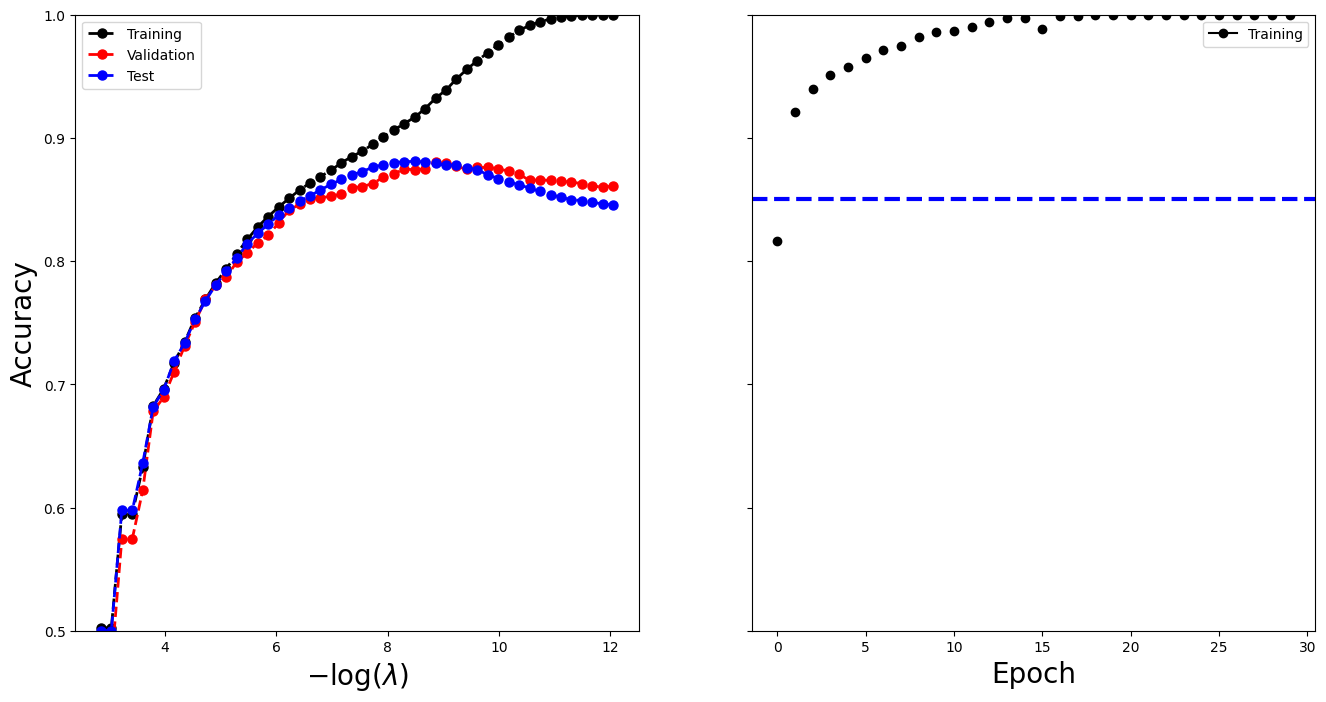

In [96]:
imdb_results = pd.read_csv(imdb_logger.experiment.metrics_file_path)
summary_plot(imdb_results,
             axes[1],
             col='accuracy',
             ylabel='Accuracy')
axes[1].set_xticks(np.linspace(0,30,7).astype(int))
axes[1].set_ylabel('Accuracy', fontsize=20)
axes[1].set_xlabel('Epoch', fontsize=20)
axes[1].set_ylim([0.5, 1])

axes[1].axhline(test_results[0]['test_accuracy'],
                color='blue',
                linestyle='--',
                linewidth=3)
fig
# The horizontal line is the test acc for the NN, its similar to logistic regression 

In [97]:
del(imdb_model,
    imdb_trainer,
    imdb_logger,
    imdb_dm,
    imdb_train,
    imdb_test)

In [8]:
# Recurrent Neural Networks
# Sentiment prediction on IMDb

In [12]:
imdb_seq_dm = SimpleDataModule(imdb_seq_train,
                               imdb_seq_test,
                               validation=2000,
                               batch_size=300,
                               num_workers=min(6, max_num_workers))

In [16]:
class LSTMModel(nn.Module):
    def __init__(self,input_size):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_size, 32) # Learned during training, one-hot encodes each doc into 500 x 10,003 
        # embedding also maps down 10,003 dimensions to 32
        self.lstm = nn.LSTM(input_size=32,
                           hidden_size=32,
                           batch_first=True) # in/out tensors are (batch, seq, feature) instead of (seq, batch, feature)
        self.dense = nn.Linear(32, 1)
    def forward(self, x):
        val, (h_n, c_n) = self.lstm(self.embedding(x))
        return torch.flatten(self.dense(val[:,-1]))

In [21]:
lstm_model = LSTMModel(X_test.shape[-1])
summary(lstm_model,
        input_data=imdb_seq_train.tensors[0], # looking at first 10 docs
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
LSTMModel                                [25000, 500]              [25000]                   --
├─Embedding: 1-1                         [25000, 500]              [25000, 500, 32]          320,096
├─LSTM: 1-2                              [25000, 500, 32]          [25000, 500, 32]          8,448
├─Linear: 1-3                            [25000, 32]               [25000, 1]                33
Total params: 328,577
Trainable params: 328,577
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 113.60
Input size (MB): 50.00
Forward/backward pass size (MB): 6400.20
Params size (MB): 1.31
Estimated Total Size (MB): 6451.51

In [22]:
lstm_module = SimpleModule.binary_classification(lstm_model)
lstm_logger = CSVLogger('logs', name='IMDB_LSTM')

In [27]:
# Training
lstm_trainer = Trainer(deterministic=True, # Sets whether pytorch operations must use deterministc algos
                       max_epochs=20,
                       logger=lstm_logger,
                       accelerator='mps',
                       callbacks=[ErrorTracker()])
lstm_trainer.fit(lstm_module,
                 datamodule=imdb_seq_dm)
                       

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory logs/IMDB_LSTM/version_0/checkpoints exists and is not empty.

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | LSTMModel         | 328 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
328 K     Trainable params
0         Non-trainable params
328 K     Total params
1.314     Total estimated model params size (MB)


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [32]:
lstm_trainer.test(lstm_module, datamodule=imdb_seq_dm)
# Accuracy is about the same as bag-of-words model

Testing: |                                                | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8493199944496155     │
│         test_loss         │    0.9847996830940247     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.9847996830940247, 'test_accuracy': 0.8493199944496155}]

(0.5, 1.0)

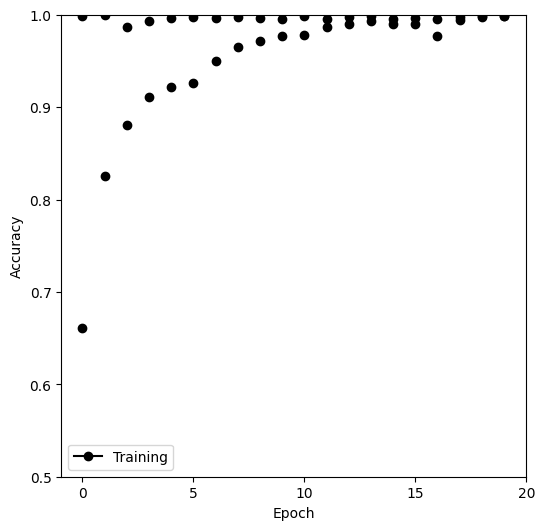

In [33]:
# Plot results
lstm_results = pd.read_csv(lstm_logger.experiment.metrics_file_path)
fig, ax = subplots(1, 1, figsize=(6,6))
summary_plot(lstm_results,
             ax,
             col='accuracy',
             ylabel='Accuracy')
ax.set_xticks(np.linspace(0, 20, 5).astype(int))
ax.set_ylabel('Accuracy')
ax.set_ylim([0.5,1])

In [8]:
# Time Series Prediction on Stock Market Data
NYSE = load_data('NYSE')
cols = ['DJ_return', 'log_volume','log_volatility']
X = pd.DataFrame(StandardScaler(with_mean=True, with_std=True)
                .fit_transform(NYSE[cols]),
                 columns=cols,
                 index=NYSE.index)

In [9]:
# Setup lagged versions of data
for lag in range(1,6):
    for col in cols:
        newcol = np.zeros(X.shape[0]) * np.nan
        newcol[lag:] = X[col].values[:-lag] 
        X.insert(len(X.columns), "{0}_{1}".format(col, lag), newcol)
X.insert(len(X.columns), 'train', NYSE['train'])
X = X.dropna()

In [10]:
# Extract response, training indicator 
Y, train = X['log_volume'], X['train']
X = X.drop(columns=['train'] + cols) # Drop today's data 
X.columns

Index(['DJ_return_1', 'log_volume_1', 'log_volatility_1', 'DJ_return_2',
       'log_volume_2', 'log_volatility_2', 'DJ_return_3', 'log_volume_3',
       'log_volatility_3', 'DJ_return_4', 'log_volume_4', 'log_volatility_4',
       'DJ_return_5', 'log_volume_5', 'log_volatility_5'],
      dtype='object')

In [11]:
# fit simple linear model and compute R^2
M = LinearRegression()
M.fit(X[train], Y[train])
M.score(X[~train], Y[~train])

0.4128912938562521

In [12]:
# Refit model including day_of_week factor variable
X_day = pd.merge(X,
                 pd.get_dummies(NYSE['day_of_week']),
                 on='date')

In [13]:
M.fit(X_day[train], Y[train])
M.score(X_day[~train],Y[~train])

0.45633025715446285

In [14]:
# Reshape data for RNN
ordered_cols = []
for lag in range(5, 0 , -1):
    for col in cols:
        ordered_cols.append('{0}_{1}'.format(col, lag))
X = X.reindex(columns=ordered_cols)
X.columns

Index(['DJ_return_5', 'log_volume_5', 'log_volatility_5', 'DJ_return_4',
       'log_volume_4', 'log_volatility_4', 'DJ_return_3', 'log_volume_3',
       'log_volatility_3', 'DJ_return_2', 'log_volume_2', 'log_volatility_2',
       'DJ_return_1', 'log_volume_1', 'log_volatility_1'],
      dtype='object')

In [15]:
# Reshape data
X_rnn = X.to_numpy().reshape((-1,5,3)) # -1 means numpy.reshape() deduces size based on remaining args
X_rnn.shape

(6046, 5, 3)

In [16]:
# RNN with 12 hidden units and 10% dropout
class NYSEModel(nn.Module):
    def __init__(self):
        super(NYSEModel, self).__init__()
        self.rnn = nn.RNN(3, 12, batch_first=True)
        self.dense = nn.Linear(12, 1)
        self.dropout = nn.Dropout(0.1)
    def forward(self, x):
        val, h_n = self.rnn(x)
        val = self.dense(self.dropout(val[:,-1])) # -1 = last time point (today)
        return torch.flatten(val)
nyse_model = NYSEModel()

In [17]:
# Format data
datasets = []
for mask in [train, ~train]:
    X_rnn_t = torch.tensor(X_rnn[mask].astype(np.float32))
    Y_t = torch.tensor(Y[mask].astype(np.float32))
    datasets.append(TensorDataset(X_rnn_t, Y_t))
nyse_train, nyse_test = datasets

In [18]:
summary(nyse_model,
        input_data=X_rnn_t,
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
NYSEModel                                [1770, 5, 3]              [1770]                    --
├─RNN: 1-1                               [1770, 5, 3]              [1770, 5, 12]             204
├─Dropout: 1-2                           [1770, 12]                [1770, 12]                --
├─Linear: 1-3                            [1770, 12]                [1770, 1]                 13
Total params: 217
Trainable params: 217
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.83
Input size (MB): 0.11
Forward/backward pass size (MB): 0.86
Params size (MB): 0.00
Estimated Total Size (MB): 0.97

In [19]:
# Put the two datasets into datamodule with batch size 64
nyse_dm = SimpleDataModule(nyse_train, nyse_test,
                           num_workers=min(4, max_num_workers),
                           validation=nyse_test,
                           batch_size=64)

NameError: name 'max_num_workers' is not defined

In [71]:
# Run some data through our model to be sure sizes match up correctly
for idx, (x,y) in enumerate(nyse_dm.train_dataloader()):
    out = nyse_model(x)
    print(y.size(), out.size())
    if idx >= 2:
        break

torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])


In [72]:
# Training
nyse_optimizer = RMSprop(nyse_model.parameters(),
                         lr=0.0005)
nyse_module = SimpleModule.regression(nyse_model,
                                      optimizer=nyse_optimizer,
                                      metrics={'r2':R2Score()}) # Requesting R^2 computed at each epoch

In [73]:
nyse_trainer = Trainer(deterministic=True,
                       max_epochs=200,
                       callbacks=[ErrorTracker()],
                       accelerator='mps')
nyse_trainer.fit(nyse_module,
                 datamodule=nyse_dm)
nyse_trainer.test(nyse_module,
                  datamodule=nyse_dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | NYSEModel | 217    | train
1 | loss  | MSELoss   | 0      | train
--------------------------------------------
217       Trainable params
0         Non-trainable params
217       Total params
0.001     Total estimated model params size (MB)


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Testing: |                                                | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     0.623192548751831     │
│          test_r2          │    0.4085599184036255     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.623192548751831, 'test_r2': 0.4085599184036255}]

In [20]:
# Now fit a nonlinear AR model 
# create test and training 
datasets = []
for mask in [train, ~train]:
    X_day_t = torch.tensor(
                np.asarray(X_day[mask]).astype(np.float32))
    Y_t = torch.tensor(np.asarray(Y[mask]).astype(np.float32))
    datasets.append(TensorDataset(X_day_t, Y_t))
day_train, day_test = datasets

In [24]:
# Creating datamodule
day_dm = SimpleDataModule(day_train,
                          day_test,
                          num_workers=max(4, 10),
                          validation=day_test,
                          batch_size=64)

In [25]:
# Build NonLinearARModel()
class NonLinearARModel(nn.Module):
    def __init__(self):
        super(NonLinearARModel, self).__init__()
        self._forward = nn.Sequential(nn.Flatten(),
                                      nn.Linear(20,32),
                                      nn.ReLU(),
                                      nn.Dropout(0.5),
                                      nn.Linear(32, 1))
    def forward(self, x):
        return torch.flatten(self._forward(x))

In [26]:
nl_model = NonLinearARModel()
nl_optimizer = RMSprop(nl_model.parameters(),
                           lr=0.001)
nl_module = SimpleModule.regression(nl_model,
                                        optimizer=nl_optimizer,
                                        metrics={'r2':R2Score()})

In [27]:
nl_trainer = Trainer(deterministic=True,
                     max_epochs=20,
                     callbacks=[ErrorTracker()],
                    accelerator='mps')
nl_trainer.fit(nl_module, datamodule=day_dm)
nl_trainer.test(nl_module, datamodule=day_dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | NonLinearARModel | 705    | train
1 | loss  | MSELoss          | 0      | train
---------------------------------------------------
705       Trainable params
0         Non-trainable params
705       Total params
0.003     Total estimated model params size (MB)


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Testing: |                                                | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5655245184898376     │
│          test_r2          │    0.46328967809677124    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5655245184898376, 'test_r2': 0.46328967809677124}]